In [1]:
## Inflation Forecast
## Target variable: Year over Year inflation
import os
import time
import pickle
import sqlite3
import numba
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import sqlite3
import random
import xgboost as xgb
import tensorflow as tf

# Seed number used
seed = 42

# Transform:
# Transformation = 'No Transform'
Transformation = 'Transform' 
# :Transforms according to the recommendations given by McCracken and Ng (2015) for all but Group 7 (Prices),
#  which are transformed as month over month growth

price_var = ['WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'OILPRICEx', 'PPICMM', 'CPIAUCSL', 
             'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 
             'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA']


In [2]:
# Make Database
database_name = 'database_predict_inflation.db'
con = sqlite3.connect(os.path.join('Data', database_name))
cur = con.cursor()

res = cur.execute("""SELECT name FROM sqlite_master WHERE type='table'""")
table_names = res.fetchall()
if ~np.isin('Results', table_names):
    print("CREATE NEW DATABASE")
    cur.execute("""CREATE TABLE IF NOT EXISTS Results(
                Date TEXT NOT NULL,
                Target TEXT NOT NULL,
                Value REAL NOT NULL,
                Prediction REAL NOT NULL,
                Model TEXT NOT NULL,
                Seed INTEGER NOT NULL,
                Parameter TEXT,
                Window_size INTEGER NOT NULL,
                Validation_size INTEGER NOT NULL,
                Transformation TEXT NOT NULL,
                PRIMARY KEY (Date, Target, Model, Seed, Window_size, Validation_size, Transformation))""")
    con.commit()
else:
    print("DATABASE ALREADY EXISTS")
    con.commit()

DATABASE ALREADY EXISTS


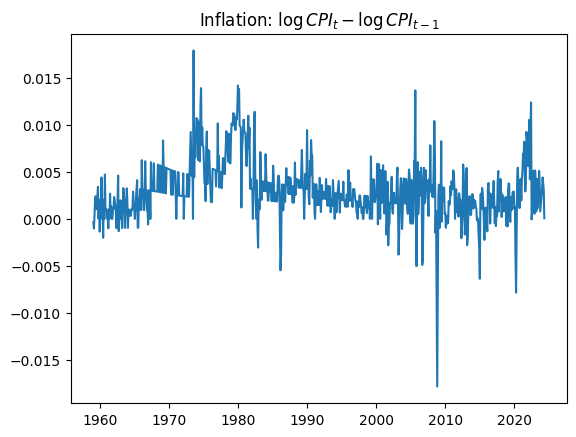

In [3]:
Data = pd.read_csv(os.path.join('Data', '2024-06.csv'))
p = Data.shape[1]

temp_list = []
for i in range(1,p):
    tcode = Data.iloc[0,i].copy()
    data = Data.iloc[1:,i].copy()
    if data.name == 'CPIAUCSL':
        data_transform = np.log(data).diff(periods=1)
    elif np.isin(data.name, list(set(price_var)-set(['CPIAUCSL']))):
        if Transformation == 'Transform':
            data_transform = np.log(data).diff(periods=1)
        else:
            data_transform = data
    else:
        if np.isin(Transformation, ['Transform']):
            if tcode == 1:
                data_transform = data
            elif tcode == 2:  # First difference
                data_transform = data.diff()
            elif tcode == 3: # Second difference
                data_transform = data.diff().diff()
            elif tcode == 4: # Log
                data_transform = np.log(data)
            elif tcode == 5: #First difference of log
                data_transform = np.log(data).diff()
            elif tcode == 6: #Second difference of natural log
                data_transform = np.log(data).diff().diff()
            elif tcode == 7: # First difference of percent change
                data_transform = data.pct_change().diff()
        elif Transformation == 'No Transform':
            data_transform = data
    temp_list.append(data_transform.copy())
Data_transform = pd.DataFrame(temp_list).T

Date = Data.iloc[1:,0]

Y = Data_transform['CPIAUCSL'] # Inflation

plt.plot(pd.to_datetime(Date),Y)
plt.title("Inflation: $\log CPI_t-\log CPI_{t-1}$")
plt.show()
# plt.savefig(os.path.join('Figures', 'inflation_yoy.png'))
# plt.close()


num_lags = 12
X = Data_transform
for p in range(1,num_lags):
    X['CPIAUCSL_lag%i' % p] = Y.shift(p).copy()

h = 1 # One step ahead forecast
X = X.shift(h)

X_used = X.iloc[12+num_lags:,:].reset_index(drop=True)
# np.sum(np.sum(np.isnan(X_used))==0)
Y_used = Y.iloc[12+num_lags:].reset_index(drop=True)

Date_used = Date.iloc[12+num_lags:].reset_index(drop=True)
Date_used = pd.to_datetime(Date_used)

# plt.plot(np.sum(~np.isnan(X_used),axis=1))
# plt.show()
n = X_used.shape[0]

forecast_period = pd.to_datetime('2015-01-01')<=Date_used
forecast_idx = np.where(forecast_period)[0]
n_test = np.sum(forecast_period)

validation_period = (pd.to_datetime('2005-08-01')<=Date_used) & (pd.to_datetime('2015-01-01') > Date_used)
validation_idx = np.where(validation_period)[0]
n_val = np.sum(validation_period)

training_period = pd.to_datetime('2005-08-01')>Date_used
training_idx = np.where(training_period)[0]
n_train = np.sum(training_period)


X_train = X_used.loc[training_period,:]
Y_train = Y_used.loc[training_period]

X_val = X_used.loc[validation_period,:]
Y_val = Y_used.loc[validation_period]

X_test = X_used.loc[forecast_period,:]
Y_test = Y_used.loc[forecast_period]

nnan_idx = np.sum(np.isnan(X_used),axis=0)==0
X_used_nnan = X_used.loc[:,nnan_idx]

X_train_nnan = X_used_nnan.loc[training_period,:]
X_val_nnan = X_used_nnan.loc[validation_period,:]
X_test_nnan = X_used_nnan.loc[forecast_period,:]

Validation_Err = {}

In [19]:
#######################################################################################
################################   AR(1), AR(12)  #####################################
#######################################################################################
OLS = LinearRegression(fit_intercept=True)
OLS.fit(X_train[['CPIAUCSL']], Y_train)
print('AR1 coefficient is %f'%OLS.coef_)

Y_hat = OLS.predict(X_test[['CPIAUCSL']])
RMSE_AR1 = np.sqrt(np.mean((Y_test-Y_hat)**2))
print('The RMSE of AR1 model is %f'%RMSE_AR1)

AR1_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'AR1',
        'Seed': seed,
        'Parameter': '',
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
AR1_out = pd.DataFrame.from_dict(AR1_out)

lags_label = ['CPIAUCSL']
for p in range(1,num_lags):
    lags_label.append('CPIAUCSL_lag%i' % p)

OLS = LinearRegression(fit_intercept=True)
OLS.fit(X_train[lags_label], Y_train)
# OLS.coef_

Y_hat = OLS.predict(X_test[lags_label])
RMSE_AR12 = np.sqrt(np.mean((Y_test-Y_hat)**2))
print('The RMSE of AR12 model is %f'%RMSE_AR12)

AR12_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'AR12',
        'Seed': seed,
        'Parameter': '',
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
AR12_out = pd.DataFrame.from_dict(AR12_out)

AR1 coefficient is 0.656401
The RMSE of AR1 model is 0.002456
The RMSE of AR12 model is 0.002445


C:\Users\sangm\AppData\Local\Temp\ipykernel_9072\3174724118.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('AR1 coefficient is %f'%OLS.coef_)


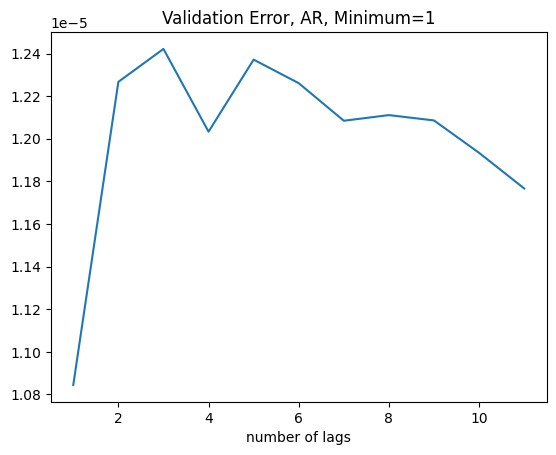

The RMSE of AR model is 0.002456


In [5]:
#######################################################################################
################################   AR, Validate  #####################################
#######################################################################################
ar_p_list = np.arange(1,12)

val_err = np.zeros((n_val, len(ar_p_list)))
AR_dict = {}
for cv_i, ar_p in enumerate(ar_p_list):
    lags_label = ['CPIAUCSL']
    for p in range(1,ar_p):
        lags_label.append('CPIAUCSL_lag%i' % p)

    AR_dict[cv_i] = LinearRegression(fit_intercept=True)
    AR_dict[cv_i].fit(X_train[lags_label], Y_train)
    # OLS.coef_

    Y_hat = AR_dict[cv_i].predict(X_val[lags_label])
    val_err[:, ar_p-1] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_AR = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['AR'] = pd.DataFrame()
Validation_Err['AR']['ar_p_list'] = ar_p_list
Validation_Err['AR']['val_err'] = val_err_AR

plt.plot(ar_p_list,val_err_AR)
plt.xlabel('number of lags')
plt.title('Validation Error, AR, Minimum=%i'%ar_p_list[min_idx])
# plt.savefig("Figures/AR_validation_seed%i.png"%seed)
# plt.close()
plt.show()

lags_label = ['CPIAUCSL']
for p in range(1,ar_p_list[min_idx]):
    lags_label.append('CPIAUCSL_lag%i' % p)

Y_hat = AR_dict[min_idx].predict(X_test[lags_label])
test_err_AR = Y_test.values - Y_hat
RMSE_AR = np.sqrt(np.sum(test_err_AR**2)/len(test_err_AR))
print('The RMSE of AR model is %f'%RMSE_AR)

AR_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'AR',
        'Seed': seed,
        'Parameter': str(ar_p_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
AR_out = pd.DataFrame.from_dict(AR_out)

In [6]:
#######################################################################################
################################   Random Walk  #######################################
#######################################################################################
Y_hat = X_test['CPIAUCSL']
RMSE_RW = np.sqrt(np.mean((Y_test-Y_hat)**2))
print('The RMSE of RW model is %f'%RMSE_RW)

RW_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat.values.reshape((-1,)),
        'Model': 'Random Walk',
        'Seed': seed,
        'Parameter': '',
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
RW_out = pd.DataFrame.from_dict(RW_out)

The RMSE of RW model is 0.002753


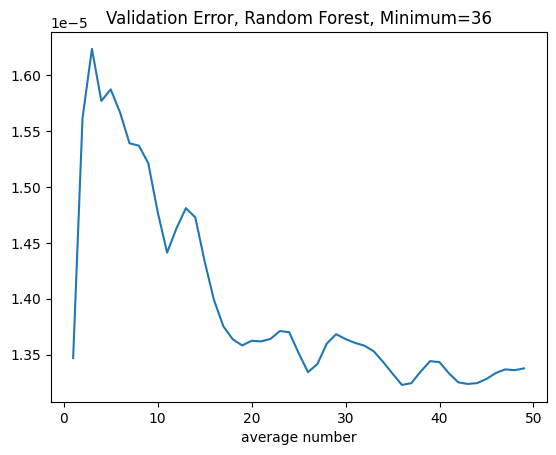

The RMSE of RA model is 0.002886


In [7]:
#######################################################################################
################################   Rolling Average  ###################################
#######################################################################################
average_n_list = np.arange(1,50,1)

val_err = np.zeros((n_val, len(average_n_list)))
Y_long = pd.concat((Y_train, Y_val),axis=0)
for i in range(len(Y_val)):
    for cv_i, average_n in enumerate(average_n_list):
        Y_hat = np.mean(Y_long.iloc[i+n_train-average_n:i+n_train])
        val_err[i, cv_i] = Y_val.iloc[i] - Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_RA = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['RA'] = pd.DataFrame()
Validation_Err['RA']['average_n_list'] = average_n_list
Validation_Err['RA']['val_err'] = val_err_RA

plt.plot(average_n_list, val_err_RA)
plt.xlabel('average number')
plt.title('Validation Error, Rolling Average, Minimum=%s'%str(average_n_list[min_idx]))
# plt.savefig("Figures/RF_validation_seed%i.png"%seed)
# plt.close()
plt.show()

test_err = np.zeros((n_test, len(average_n_list)))
Y_long = pd.concat((Y_val, Y_test),axis=0)
Y_hat = np.zeros((n_test,))
for i in range(len(Y_test)):
    for cv_i, average_n in enumerate(average_n_list):
        Y_hat[i] = np.mean(Y_long.iloc[i+n_val-average_n:i+n_val])
        test_err[i, cv_i] = Y_test.iloc[i] - Y_hat[i]

RMSE_RA = np.sqrt(np.mean(np.array(test_err)**2, axis=0))[min_idx]
print('The RMSE of RA model is %f'%RMSE_RA)
RA_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'Random Forest',
        'Seed': seed,
        'Parameter': str(average_n_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
RA_out = pd.DataFrame.from_dict(RA_out)

elapsed time = 51.46 sec; 2024-08-17 02:15:12.730269


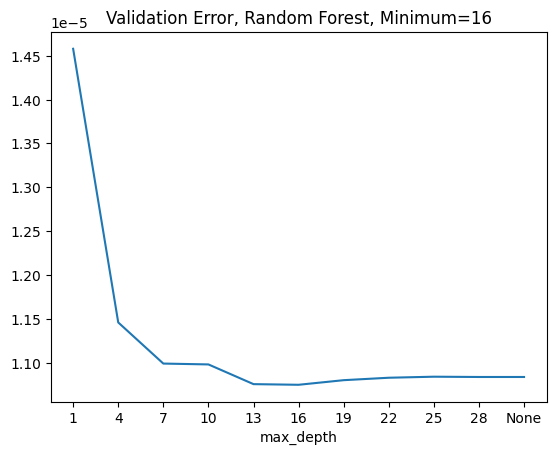

The RMSE of RF model is 0.002249


In [8]:
#######################################################################################
################################   Random Forest  #####################################
#######################################################################################
max_depth_list = np.append(np.arange(1,30,3),None)

err_sq = np.zeros(forecast_idx.shape[0],)
val_err = np.zeros((n_val, len(max_depth_list)))
RFmodel_dict = {}
t = time.time()
for cv_i, max_depth in enumerate(max_depth_list):
    RFmodel_dict[cv_i] = RandomForestRegressor(n_estimators=100, criterion='squared_error',
                                    max_depth=max_depth, min_samples_split=2, min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0, max_features=1.0, max_leaf_nodes=None,
                                    min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None,
                                    random_state=seed, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)    
    RFmodel_dict[cv_i].fit(X_train_nnan, Y_train)
    Y_hat = RFmodel_dict[cv_i].predict(X_val_nnan)
    val_err[:, cv_i] = Y_val.values-Y_hat
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_RF = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['RF'] = pd.DataFrame()
Validation_Err['RF']['max_depth_list'] = max_depth_list
Validation_Err['RF']['val_err'] = val_err_RF

temp_grid = ['None' if x==None else x for x in max_depth_list]
plt.plot(temp_grid, val_err_RF)
plt.xlabel('max_depth')
plt.title('Validation Error, Random Forest, Minimum=%s'%str(temp_grid[min_idx]))
# plt.savefig("Figures/RF_validation_seed%i.png"%seed)
# plt.close()
plt.show()

Y_hat = RFmodel_dict[min_idx].predict(X_test_nnan)
test_err_RF = Y_test.values - Y_hat
RMSE_RF = np.sqrt(np.sum(test_err_RF**2)/len(test_err_RF))
print('The RMSE of RF model is %f'%RMSE_RF)

RF_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'Random Forest',
        'Seed': seed,
        'Parameter': str(max_depth_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
RF_out = pd.DataFrame.from_dict(RF_out)


elapsed time = 4.48 sec; 2024-08-17 02:15:17.346648


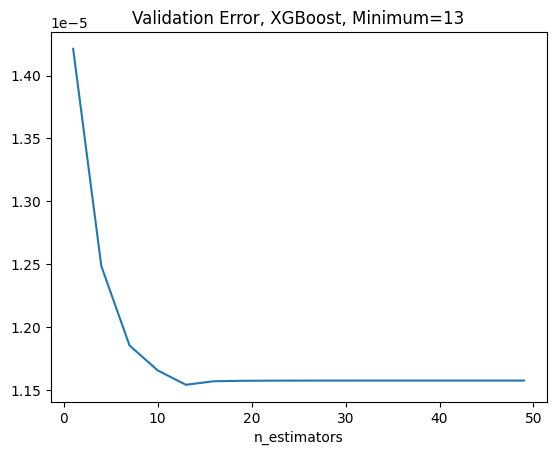

The RMSE of XGB model is 0.002284


In [9]:
#######################################################################################
###################################   XGBoost  ########################################
#######################################################################################
n_estimators_list = np.arange(1,50,3)
val_err = np.zeros((n_val,len(n_estimators_list)))
XGBmodel_dict = {}
t = time.time()
for cv_i, n_estimators in enumerate(n_estimators_list):
    XGBmodel_dict[cv_i] = xgb.XGBRegressor(n_jobs=1, tree_method="exact", n_estimators=n_estimators, random_state=seed)
    XGBmodel_dict[cv_i].fit(X_train_nnan, Y_train)
    Y_hat = XGBmodel_dict[cv_i].predict(X_val_nnan) 
    val_err[:, cv_i] = Y_val.values-Y_hat
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_XGB = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['XGB'] = pd.DataFrame()
Validation_Err['XGB']['n_estimators_list'] = n_estimators_list
Validation_Err['XGB']['val_err'] = val_err_XGB

plt.plot(n_estimators_list,val_err_XGB)
plt.xlabel('n_estimators')
plt.title('Validation Error, XGBoost, Minimum=%i'%n_estimators_list[min_idx])
# plt.savefig("Figures/XGB_validation_seed%i.png"%seed)
# plt.close()
plt.show()

Y_hat = XGBmodel_dict[min_idx].predict(X_test_nnan)
test_err_XGB = Y_test.values - Y_hat
RMSE_XGB = np.sqrt(np.sum(test_err_XGB**2)/len(test_err_XGB))
print('The RMSE of XGB model is %f'%RMSE_XGB)

XGB_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'XGBoost',
        'Seed': seed,
        'Parameter': str(n_estimators_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
XGB_out = pd.DataFrame.from_dict(XGB_out)

elapsed time = 43.48 sec; 2024-08-17 02:16:00.956761
The RMSE of XGBs model is 0.002260


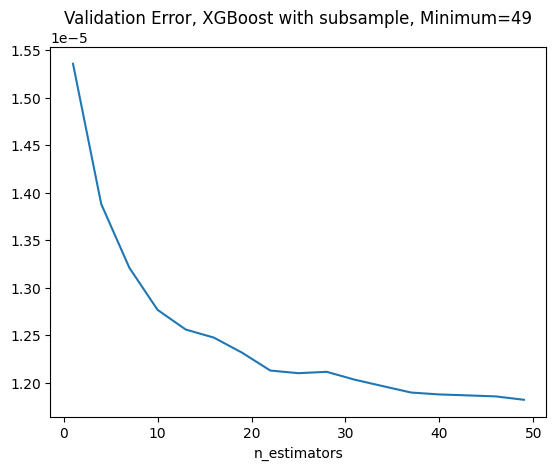

In [10]:
#######################################################################################
##############################   XGBoost with subsampling #############################
#######################################################################################

num_parallel_tree = 100
subsample = np.sqrt(X_train_nnan.shape[0])/X_train_nnan.shape[0]
n_estimators_list = np.arange(1,50,3)
val_err = np.zeros((n_val,len(n_estimators_list)))
XGBmodel_dict = {}
t = time.time()
for cv_i, n_estimators in enumerate(n_estimators_list):
    XGBmodel_dict[cv_i] = xgb.XGBRegressor(n_jobs=1, tree_method="exact", subsample=subsample,
                                            num_parallel_tree=num_parallel_tree,
                                            n_estimators=n_estimators, random_state=seed)
    XGBmodel_dict[cv_i].fit(X_train_nnan, Y_train)
    Y_hat = XGBmodel_dict[cv_i].predict(X_val_nnan)
    val_err[:, cv_i] = Y_val.values-Y_hat
elapsed = time.time() - t
print('elapsed time = %0.2f sec; %s'%(elapsed, datetime.datetime.now()))

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_XGBs = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['XGBs'] = pd.DataFrame()
Validation_Err['XGBs']['n_estimators_list'] = n_estimators_list
Validation_Err['XGBs']['val_err'] = val_err_XGBs

plt.plot(n_estimators_list, val_err_XGBs)
plt.xlabel('n_estimators')
plt.title('Validation Error, XGBoost with subsample, Minimum=%i'%n_estimators_list[min_idx])
# plt.savefig("Figures/XGBs_validation_seed%i.png"%seed)
# plt.close()
# # plt.show()

Y_hat = XGBmodel_dict[min_idx].predict(X_test_nnan)
test_err_XGBs = Y_test.values - Y_hat
RMSE_XGBs = np.sqrt(np.sum(test_err_XGBs**2)/len(test_err_XGBs))
print('The RMSE of XGBs model is %f'%RMSE_XGBs)

XGBs_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'XGBoost-subsample',
        'Seed': seed,
        'Parameter': str(n_estimators_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
XGBs_out = pd.DataFrame.from_dict(XGBs_out)

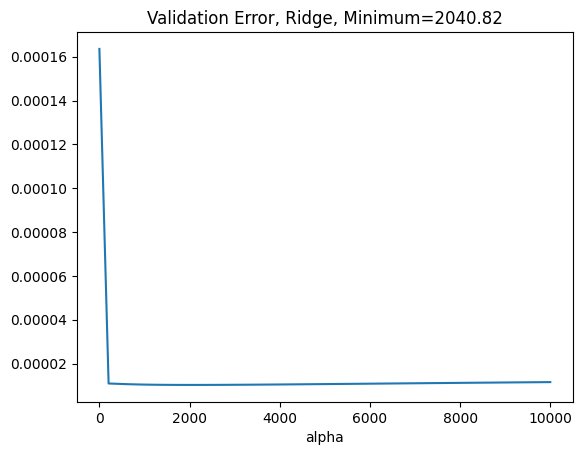

The RMSE of Ridge model is 0.002286


In [11]:
#######################################################################################
###################################   Ridge    ########################################
#######################################################################################
X_train_stzd = (X_train_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_val_stzd = (X_val_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_test_stzd = (X_test_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)    

alpha_list =np.linspace(0,10000,50)
val_err = np.zeros((n_val,len(alpha_list)))
Ridgemodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    Ridgemodel_dict[cv_i] = Ridge(alpha=alpha,fit_intercept=True, random_state=seed)
    Ridgemodel_dict[cv_i].fit(X_train_stzd, Y_train)
    Y_hat = Ridgemodel_dict[cv_i].predict(X_val_stzd) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_Ridge = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['Ridge'] = pd.DataFrame()
Validation_Err['Ridge']['alpha_list'] = alpha_list
Validation_Err['Ridge']['val_err'] = val_err_Ridge

plt.plot(alpha_list,val_err_Ridge)
plt.xlabel('alpha')
plt.title('Validation Error, Ridge, Minimum=%0.2f'%alpha_list[min_idx])
plt.show()
# plt.savefig("Figures/Ridge_validation_seed%i.png"%seed)
# plt.close()

min_idx_ridge = min_idx
Y_hat = Ridgemodel_dict[min_idx].predict(X_test_stzd)
test_err_Ridge = Y_test.values - Y_hat
RMSE_Ridge = np.sqrt(np.sum(test_err_Ridge**2)/len(test_err_Ridge))
print('The RMSE of Ridge model is %f'%RMSE_Ridge)

Ridge_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'Ridge',
        'Seed': seed,
        'Parameter': str(alpha_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
Ridge_out = pd.DataFrame.from_dict(Ridge_out)


C:\Users\sangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.565e-04, tolerance: 4.769e-07
  model = cd_fast.enet_coordinate_descent(


           Variable Estimates
0   DPCERA3M086SBEA  0.000058
1         IPB51222S  0.000025
2          UEMP15OV -0.000011
3     CES1021000001  0.000006
4          USWTRADE  0.000081
5           HOUSTMW  0.000043
6            HOUSTW  0.000112
7          NONREVSL -0.000087
8          FEDFUNDS  0.000079
9               GS5  0.000085
10         TB3SMFFM -0.000049
11         TB6SMFFM -0.000059
12           T5YFFM -0.000253
13           AAAFFM -0.000076
14       WPSFD49207  0.000221
15        OILPRICEx   0.00039
16           PPICMM  0.000019
17      CUSR0000SAD  0.000387
18      CUSR0000SAS  0.000003
19    CUSR0000SA0L5   0.00038
20            PCEPI  0.000119
21    CPIAUCSL_lag1  0.000104
22    CPIAUCSL_lag2  0.000022
23    CPIAUCSL_lag3  0.000042
24    CPIAUCSL_lag4  0.000235
25    CPIAUCSL_lag6   0.00009
26    CPIAUCSL_lag8  0.000363
27    CPIAUCSL_lag9  0.000149
28   CPIAUCSL_lag10  0.000179
The RMSE of LASSO is 0.002253


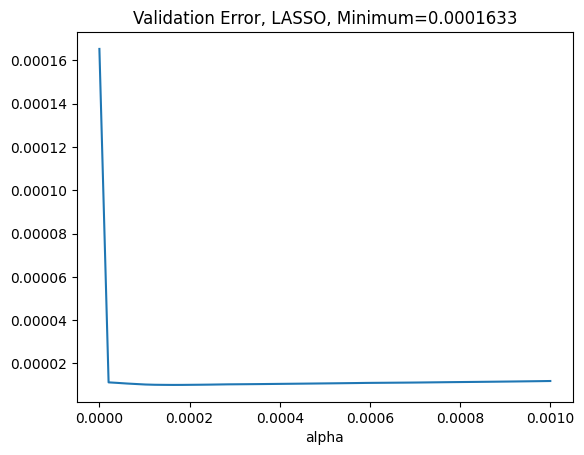

In [12]:
#######################################################################################
###################################   LASSO    ########################################
#######################################################################################
alpha_list = np.linspace(1e-14,0.001,50)
val_err = np.zeros((n_val,len(alpha_list)))
Lassomodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    Lassomodel_dict[cv_i] = Lasso(alpha=alpha, fit_intercept=True,  warm_start=True,
                                  random_state=seed, max_iter=10000)
    Lassomodel_dict[cv_i].fit(X_train_stzd, Y_train)
    Y_hat = Lassomodel_dict[cv_i].predict(X_val_stzd) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_Lasso = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['LASSO'] = pd.DataFrame()
Validation_Err['LASSO']['alpha_list'] = alpha_list
Validation_Err['LASSO']['val_err'] = val_err_Lasso

plt.plot(alpha_list, val_err_Lasso)
plt.xlabel('alpha')
plt.title('Validation Error, LASSO, Minimum=%0.7f'%alpha_list[min_idx])
# plt.savefig("Figures/LASSO_validation_seed%i.png"%seed)
# plt.close()
# plt.show()
nonzero_beta = pd.DataFrame(((X_train_stzd.columns[Lassomodel_dict[min_idx].coef_ !=0],
                            Lassomodel_dict[min_idx].coef_[Lassomodel_dict[min_idx].coef_ !=0]))).T
nonzero_beta.columns = ['Variable','Estimates']
print(nonzero_beta)

Y_hat = Lassomodel_dict[min_idx].predict(X_test_stzd)
test_err_Lasso = Y_test.values - Y_hat
RMSE_Lasso = np.sqrt(np.sum(test_err_Lasso**2)/len(test_err_Lasso))
print('The RMSE of LASSO is %f'%RMSE_Lasso)

Lasso_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'LASSO',
        'Seed': seed,
        'Parameter': str(alpha_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
Lasso_out = pd.DataFrame.from_dict(Lasso_out)

C:\Users\sangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.508e-04, tolerance: 4.769e-07
  model = cd_fast.enet_coordinate_descent(


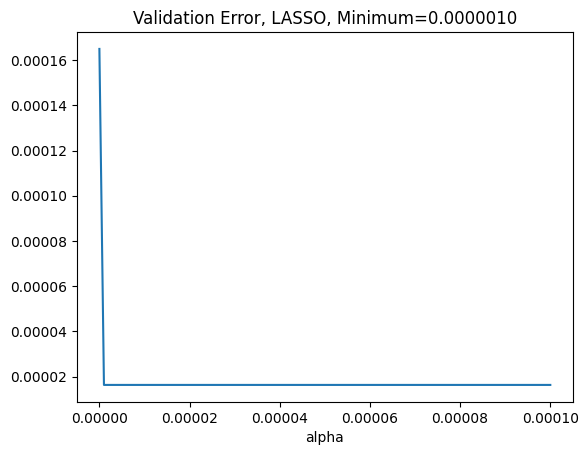

Empty DataFrame
Columns: [Variable, Estimates]
Index: []
The RMSE of Adaptive LASSO is 0.003073


In [13]:
#######################################################################################
###################################   ADALASSO    #####################################
#######################################################################################
X_train_stzd_tilde = X_train_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)
X_val_stzd_tilde = X_val_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)
X_test_stzd_tilde = X_test_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)

alpha_list = np.linspace(1e-14,0.0001,100)
val_err = np.zeros((n_val,len(alpha_list)))
AdaLassomodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    AdaLassomodel_dict[cv_i] = Lasso(alpha=alpha, fit_intercept=True,  warm_start=True,
                                     random_state=seed, max_iter=10000)
    AdaLassomodel_dict[cv_i].fit(X_train_stzd_tilde, Y_train)
    Y_hat = AdaLassomodel_dict[cv_i].predict(X_val_stzd_tilde) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_AdaLasso = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['ADALASSO'] = pd.DataFrame()
Validation_Err['ADALASSO']['alpha_list'] = alpha_list
Validation_Err['ADALASSO']['val_err'] = val_err_AdaLasso

plt.plot(alpha_list, val_err_AdaLasso)
plt.xlabel('alpha')
plt.title('Validation Error, LASSO, Minimum=%0.7f'%alpha_list[min_idx])
# plt.savefig("Figures/LASSO_validation_seed%i.png"%seed)
# plt.close()
plt.show()
nonzero_beta = pd.DataFrame(((X_train_stzd.columns[AdaLassomodel_dict[min_idx].coef_ !=0],
                            AdaLassomodel_dict[min_idx].coef_[AdaLassomodel_dict[min_idx].coef_ !=0]))).T
nonzero_beta.columns = ['Variable','Estimates']
print(nonzero_beta)

Y_hat = AdaLassomodel_dict[min_idx].predict(X_test_stzd_tilde)
test_err_Lasso = Y_test.values - Y_hat
RMSE_AdaLasso = np.sqrt(np.sum(test_err_Lasso**2)/len(test_err_Lasso))
print('The RMSE of Adaptive LASSO is %f'%RMSE_AdaLasso)
# plt.plot(Y_test.values)
# plt.plot(Y_hat)
# plt.show()

AdaLasso_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'LASSO',
        'Seed': seed,
        'Parameter': str(alpha_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
AdaLasso_out = pd.DataFrame.from_dict(AdaLasso_out)


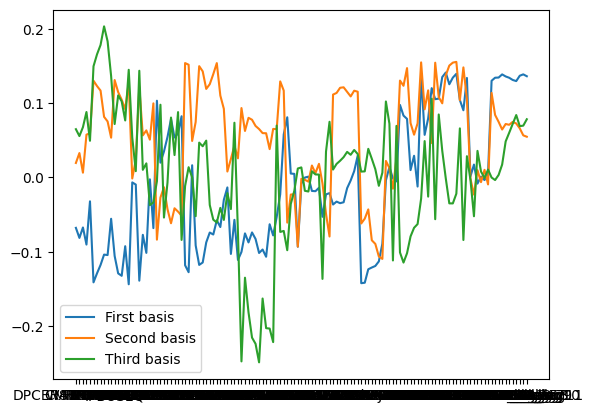

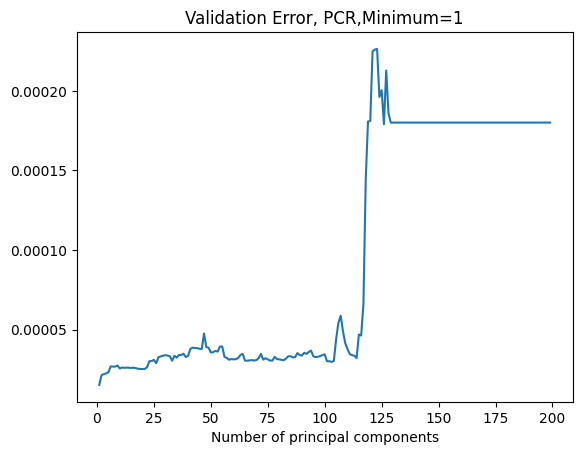

The RMSE of PCR is 0.005065


In [14]:
#######################################################################################
####################################   PCR    #########################################
#######################################################################################
Sigma_hat = X_train_stzd.T@X_train_stzd/n_train
eigval, eigvec = np.linalg.eig((Sigma_hat+Sigma_hat.T)/2)
eigval = np.real(eigval)
eigvec = np.real(eigvec)
idx = eigval.argsort()[::-1]
eigval_sorted = eigval[idx]
eigvec_sorted = eigvec[:, idx]
F_train = X_train_stzd @ eigvec_sorted
F_val = X_val_stzd @ eigvec_sorted
F_val.columns = F_train.columns
F_test = X_test_stzd @ eigvec_sorted
F_test.columns = F_test.columns


# fig, ax = plt.subplots()
plt.plot(X_train_stzd.columns,eigvec_sorted[:,0], label='First basis')
plt.plot(X_train_stzd.columns,eigvec_sorted[:,1], label='Second basis')
plt.plot(X_train_stzd.columns,eigvec_sorted[:,2], label='Third basis')
# plt.xticks(rotation=-45)
plt.legend()
plt.show()


nfactors_list = np.arange(1,200)
val_err = np.zeros((n_val, len(nfactors_list)))
nfactors = 2
OLS_dict = {}
for cv_i, nfactors in enumerate(nfactors_list):
    OLS = LinearRegression(fit_intercept=False)
    OLS_dict[cv_i] = OLS.fit(F_train.iloc[:,:nfactors], Y_train)
    Y_hat = OLS_dict[cv_i].predict(F_val.iloc[:,:nfactors])
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_PCR = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['PCR'] = pd.DataFrame()
Validation_Err['PCR']['nfactors_list'] = nfactors_list
Validation_Err['PCR']['val_err'] = val_err_PCR

plt.plot(nfactors_list, val_err_PCR)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCR,Minimum=%i'%nfactors_list[min_idx])
plt.show()
# plt.savefig("Figures/PCR_validation_seed%i.png"%seed)
# plt.close()
# plt.show()

Y_hat = OLS_dict[min_idx].predict(F_test.iloc[:,:nfactors_list[min_idx]])
test_err_PCR = Y_test.values - Y_hat
RMSE_PCR = np.sqrt(np.sum(test_err_PCR**2)/len(test_err_PCR))
print('The RMSE of PCR is %f'%RMSE_PCR)

PCR_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat,
        'Model': 'PCR',
        'Seed': seed,
        'Parameter': str(nfactors_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
PCR_out = pd.DataFrame.from_dict(PCR_out)

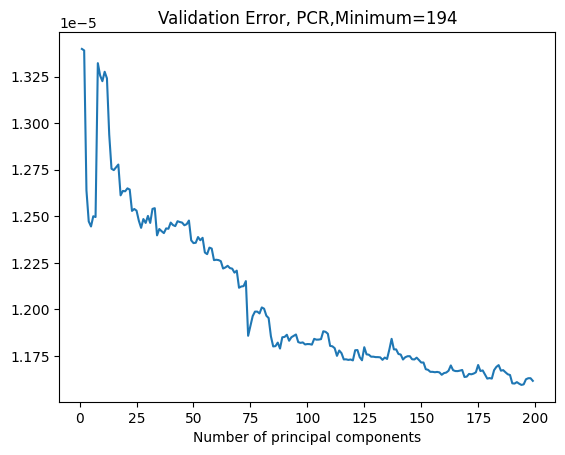

The RMSE of RKHS regression is 0.003568


In [15]:
#######################################################################################
###################################  RKHS regression  #################################
#######################################################################################
@numba.njit
def get_Gram(X,n,gamma):
    Gram_rbf = np.zeros((n,n))
    for t in range(n):
        Gram_rbf[t,:] = np.exp(-gamma*np.sum((X[t,:]-X)**2,1))
    return Gram_rbf

@numba.njit
def get_Gram_test(X_train,X_test,n_train,n_test,gamma):
    Gram_rbf = np.zeros((n_test,n_train))
    for t in range(n_test):
        Gram_rbf[t,:] = np.exp(-gamma*np.sum((X_test[t,:]-X_train)**2,1))
    return Gram_rbf

gamma = 1/X_train_stzd.shape[1]
# gamma = 1
Kernel_Gram = get_Gram(X_train_stzd.values, X_train_stzd.shape[0],gamma)
eigenvalues, eigenvectors = np.linalg.eigh(Kernel_Gram)

idx = eigenvalues.argsort()[::-1]
eigval_sorted = eigenvalues[idx]
eigvec_sorted = eigenvectors[:, idx]

F_train = eigvec_sorted*eigval_sorted
K_val = get_Gram_test(X_train_stzd.values, X_val_stzd.values, n_train, n_val, gamma)
K_test = get_Gram_test(X_train_stzd.values, X_val_stzd.values, n_train, n_test, gamma)
F_val = K_val@eigvec_sorted
F_test = K_test@eigvec_sorted

nfactors_list = np.arange(1,200)
val_err = np.zeros((n_val, len(nfactors_list)))
nfactors = 2
lam = 0
RKHS_dict = {}
for cv_i, nfactors in enumerate(nfactors_list):
    
    delta_hat = np.linalg.inv(F_train[:,:nfactors].T@F_train[:,:nfactors]+lam*np.diag(eigval_sorted[:nfactors]))@F_train[:,:nfactors].T@Y_train
    Y_hat = F_val[:,:nfactors]@delta_hat
    RKHS_dict[cv_i] = delta_hat
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_RKHS = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['RKHS'] = pd.DataFrame()
Validation_Err['RKHS']['nfactors_list'] = nfactors_list
Validation_Err['RKHS']['val_err'] = val_err_RKHS

plt.plot(nfactors_list, val_err_RKHS)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCR,Minimum=%i'%nfactors_list[min_idx])
plt.show()
# plt.savefig("Figures/PCR_validation_seed%i.png"%seed)
# plt.close()
# # plt.show()


Y_hat = F_test[:,:nfactors_list[min_idx]]@RKHS_dict[min_idx]
test_err_RKHS = Y_test.values - Y_hat
RMSE_RKHS = np.sqrt(np.sum(test_err_RKHS**2)/len(test_err_RKHS))
print('The RMSE of RKHS regression is %f'%RMSE_RKHS)

# plt.plot(Y_test.values)
# plt.plot(Y_hat)
# plt.show()

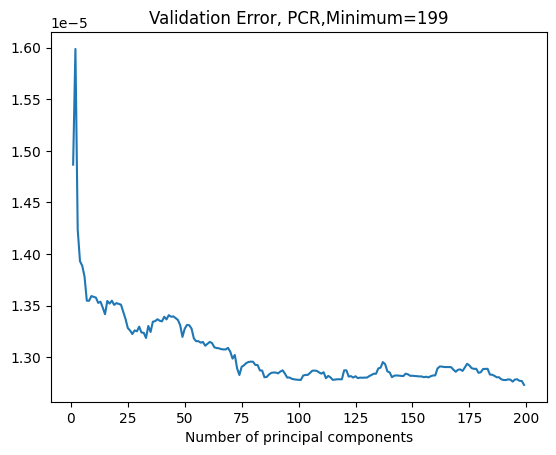

In [16]:
#######################################################################################
###################################  RKHS regression demean ###########################
#######################################################################################

gamma = 1/X_train_stzd.shape[1]
Kernel_Gram = get_Gram(X_train_stzd.values, X_train_stzd.shape[0],gamma)

temp = Kernel_Gram - np.mean(Kernel_Gram,axis=1).reshape(-1,1)
Kernel_Gram_dm = temp - np.mean(temp,axis=0)

eigenvalues, eigenvectors = np.linalg.eigh(Kernel_Gram_dm)

idx = eigenvalues.argsort()[::-1]
eigval_sorted = eigenvalues[idx]
eigvec_sorted = eigenvectors[:, idx]

F_train = eigvec_sorted*eigval_sorted
F_train_dm = F_train - np.mean(F_train,0)
K_val = get_Gram_test(X_train_stzd.values, X_val_stzd.values, n_train, n_val, gamma)
K_test = get_Gram_test(X_train_stzd.values, X_val_stzd.values, n_train, n_test, gamma)
F_val = K_val@eigvec_sorted
F_test = K_test@eigvec_sorted

nfactors_list = np.arange(1,200)
val_err = np.zeros((n_val, len(nfactors_list)))
nfactors = 2
lam = 0
RKHS_dict = {}
for cv_i, nfactors in enumerate(nfactors_list):
    delta_hat = np.linalg.inv(F_train[:,:nfactors].T@F_train_dm[:,:nfactors]+lam*np.diag(eigval_sorted[:nfactors]))@F_train_dm[:,:nfactors].T@Y_train
    alpha_hat = eigvec_sorted[:,:nfactors]@delta_hat
    beta_hat = np.mean(Y)

    Y_hat = beta_hat + F_val[:,:nfactors]@delta_hat
    RKHS_dict[cv_i] = [beta_hat,delta_hat]
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_RKHS = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['RKHS'] = pd.DataFrame()
Validation_Err['RKHS']['nfactors_list'] = nfactors_list
Validation_Err['RKHS']['val_err'] = val_err_RKHS

plt.plot(nfactors_list, val_err_RKHS)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCR,Minimum=%i'%nfactors_list[min_idx])
# # plt.show()
# plt.savefig("Figures/PCR_validation_seed%i.png"%seed)
# plt.close()
# # plt.show()

# temp = LinearRegression(fit_intercept=True)
# temp.fit(pd.concat((V_train,W_train_stzd),axis=1),Y_train)
# Y_hat = temp.predict(pd.concat((V_test,W_test_stzd),axis=1))

Y_hat = RKHS_dict[min_idx][0]+F_test[:,:nfactors_list[min_idx]]@RKHS_dict[min_idx][1]
test_err_RKHS = Y_test.values - Y_hat
RMSE_RKHS = np.sqrt(np.sum(test_err_RKHS**2)/len(test_err_RKHS))


The RMSE of NN is 3.867271


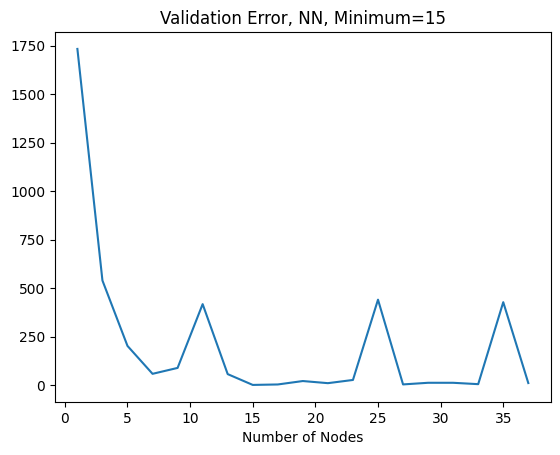

In [17]:
#######################################################################################
###################################   Neural Net    ###################################
#######################################################################################
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

batch_size = X_train_nnan.shape[0]
epochs = 20
n_node_list = np.linspace(1,37,19).astype(int)
val_err = np.zeros((n_val, len(n_node_list)))
model_FF_dict = {}
for cv_i, n_node in enumerate(n_node_list):
    model_FF = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(X_train_nnan.shape[1],)),
            tf.keras.layers.Dense(n_node, activation="relu"),
            # tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1)
        ]
    )
    # model_FF.summary()
    
    model_FF.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
    

    model_FF.fit(X_train_nnan, Y_train, batch_size=batch_size,
            epochs=epochs,verbose=0)
    
    Y_hat = model_FF.predict(X_val_nnan,verbose=0)
    model_FF_dict[cv_i] = model_FF
    val_err[:, cv_i] = Y_val.values - Y_hat.reshape(-1,)
    
min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_NN = np.mean(np.array(val_err)**2, axis=0)

Validation_Err['NN'] = pd.DataFrame()
Validation_Err['NN']['n_node_list'] = n_node_list
Validation_Err['NN']['val_err'] = val_err_NN

plt.plot(n_node_list, val_err_NN)
plt.xlabel('Number of Nodes')
plt.title('Validation Error, NN, Minimum=%i'%n_node_list[min_idx])
# plt.show()
# plt.savefig("Figures/NN_validation_seed%i.png"%seed)
# plt.close()

Y_hat = model_FF_dict[min_idx].predict(X_test_nnan,verbose=0)
test_err_FF = Y_test.values - Y_hat.reshape((-1,))
RMSE_FF = np.sqrt(np.sum(test_err_FF**2)/len(test_err_FF))
print('The RMSE of NN is %f'%RMSE_FF)

NN_out = {'Date': Date_used[forecast_idx].dt.strftime("%m/%d/%Y").values,
        'Target': 'Inflation',
        'Value': Y_test.values,
        'Prediction': Y_hat.reshape((-1,)),
        'Model': 'NN',
        'Seed': seed,
        'Parameter': str(n_node_list[min_idx]),
        'Window_size': n_train,
        'Validation_size': n_val,
        'Transformation': Transformation
        }
NN_out = pd.DataFrame.from_dict(NN_out)



In [18]:
# out = np.concatenate((RW_out.values, AR1_out.values, AR12_out.values, AR_out.values,RF_out.values, XGB_out.values, XGBs_out.values, Lasso_out.values, Ridge_out.values, PCR_out.values, RKHS_out.values, NN_out.values), axis=0)

# query = ''' insert or replace into Results (Date,Target,Value,Prediction,Model,Seed,Parameter,Window_size,Validation_size,Transformation) values (?,?,?,?,?,?,?,?,?,?) '''
# cur.executemany(query, out)
# con.commit()
# con.close()

# file_name ='Validation_Err_seed%i_%s.pkl'%(seed, Transformation.replace(' ','_'))

# with open(os.path.join('Results', file_name), 'wb') as outp:
#     pickle.dump(Validation_Err, outp)